# Calibrating the HAT-P-1b NIRISS/SOSS observations with the JWST Pipeline
--------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: August 19, 2020.

## Table of contents
1. [Introduction](#intro)
2. [Passing the data through the JWST calibration pipeline](#jwstpipeline)

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

Given a simulated or real dataset, we now have to calibrate it using the [JWST calibration pipeline](https://github.com/spacetelescope/jwst) (simply defined as the "JWST pipeline", from now on), as the raw, uncalibrated data has various instrumental effects such as a bias pedestal, dark currents, non-linearity effects, etc. that we want to calibrate/remove/take care of before taking a deep dive into the data reduction on our own. As it is explained in the [pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/index.html), the JWST pipeline consists of three stages: [the first](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) performs detector-level corrections, the second one, divided between [spectroscopy](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2) and [imaging](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html) one performs instrument-speciic calibrations and the third stage, which is divided by scientific output which in our case is the [TSO3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html) one corresponding to time-series observations, combines that data in order to produce a final product.

If you haven't installed the pipeline yet, this is the time to do it. The steps are very simple; just pip-install the latest version of the [JWST pipeline from the Github repo](https://github.com/spacetelescope/jwst), and then set some enviornment data so the pipeline knows where to get the reference data to perform the reductions (see below). If in Mac OSX, for example, open a terminal and do:

`export CRDS_PATH=$HOME/crds_cache`

`export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`

And then you are all set!

If all worked correctly, you should be able to import the pipeline calls below:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits 
from astropy.utils.data import download_file

from jwst.pipeline import calwebb_detector1, calwebb_spec2
from jwst import datamodels

2.<font color='white'>-</font>Passing the data through the JWST calibration pipeline <a class="anchor" id="jwstpipeline"></a>
------------------

Let's pass our uncalibrated data through the JWST calibration pipeline. Here, we will pass it only through Stage 1 (i.e., detector-level calibrations for time-series observations) and part of Stage 2 (i.e., spectroscopic processing) --- up to the spectral extraction part. We will then extract the spectra from these products with our own algorithms in the next notebook. The reason for doing this is to provide the community with a basic understanding of the most basic products the pipeline provides, so they can more easily apply methods used in other instruments (e.g., HST, ground-based transit spectroscopy) to JWST observations.

There are various ways of running the JWST pipeline, including a couple options in which by running basically two lines of code one can pass the entire datastet through the two stages. However, in order to be as clear as possible, and to make this step self-sufficient, we will apply each step of the pipeline individually on our own. This will in turn showcase the versatility of the JWST pipeline, and showcase one of its main features: its modularity. We will start following the steps defined for TSOs on [Stage 1 of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1), and will then move to the steps followed by spectroscopic TSOs in [Stage 2 of the pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2). 

### A. Stage 1: accounting for detector-level calibrations

We here follow almost all the steps that are usually followed by the pipeline for TSOs in what follows for Stage 1. The details for each of those steps can be checked in the [pipeline ReadTheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) --- we here give a brief overview of what each of those steps do. 

We will skip the `group_scale` step of the pipeline, which in theory is the first one that is applied to TSOs, because that step is only relevant for groups with multiple frames. Given NIRISS/SOSS has only one frame per group, this step wouldn't do anything to our dataset. We jump straight to the `dq_init` step. This step initializes a Data Quality (DQ) mask, so each pixel has an associated DQ flag to it. This is based on analyses done by the NIRISS team, which have already identified problematic pixels that other steps of the pipeline should be careful with. We are careful and create a folder called `pipeline_outputs` as well to save the intermediate results we will be using of the pipeline (in case we want to take a look at them):

In [2]:
# In case user has not run the previous notebook, we download. the data_uncal.fits file which has the uncalibrated 
# simulated data:
#if not os.path.exists('data_uncal.fits'):
    #file_path = download_file('https://data.science.stsci.edu/redirect/'+\
    #                          'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/data_uncal.fits')
    #os.rename(file_path,'data_uncal.fits')
    
# Create folder on which we will be saving the pipeline outputs:
os.mkdir('pipeline_outputs')
# Run the first pipeline step:
calwebb_detector1.dq_init_step.DQInitStep.call('data_uncal.fits', output_dir='pipeline_outputs',save_results=True)

2020-08-22 13:17:28,941 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-08-22 13:17:28,949 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2020-08-22 13:17:30,487 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('data_uncal.fits',).
2020-08-22 13:17:30,489 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-22 13:17:46,208 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0014.fits
2020-08-22 13:18:19,199 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2020-08-22 13:18:19,260 - stpipe.DQInitStep - WARNING - /Users/nespinoza/anaco

<RampModel(1198, 3, 256, 2048) from data_dqinitstep.fits>

All right! This is done. Next, let's apply the `saturation` step on these products. This will simply add a flag to pixels that are saturated (which will be ommited from further analyses). Once again, the saturation limits of each pixel have also been analyzed by the NIRISS team --- these values are stored in reference files that the pipeline uses to flag the pixels:

In [3]:
calwebb_detector1.saturation_step.SaturationStep.call('pipeline_outputs/data_dqinitstep.fits', \
                                                      output_dir='pipeline_outputs',save_results=True)

2020-08-22 13:19:39,200 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-08-22 13:19:39,206 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2020-08-22 13:19:40,227 - stpipe.SaturationStep - INFO - Step SaturationStep running with args ('pipeline_outputs/data_dqinitstep.fits',).
2020-08-22 13:19:40,229 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-08-22 13:19:53,460 - stpipe.SaturationStep - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0010.fits
2020-08-22 13:20:40,447 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science

<RampModel(1198, 3, 256, 2048) from data_saturationstep.fits>

The next step that follows is the `superbias` step. In theory, that step simply substracts a super Bias frame to our uncalibrated data, in order to remove the detector "pedestal" of the detector. However, we will manually substract this superbias frame here, because `awesimsoss` v.0.3.3 (the NIRISS/SOSS simulator we used to generate this data) uses a different bias frame to the one the pipeline uses by default:  

In [4]:
hdul = fits.open('pipeline_outputs/data_saturationstep.fits')
# Retrive bias frame:
file_path = download_file('https://data.science.stsci.edu/redirect/'+\
                          'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/reference_files/pedestaldms.fits')
# Open it, cut it (original one is a full frame bias --- so we cut it to match SUBSTRIP256)
hdul_pedestal = fits.open(file_path)
superbias = hdul_pedestal['PRIMARY'].data[-256:,:]
# Correct this bias frame on the data:
hdul['SCI'].data -= superbias

The step following the `superbias` step would be the `refpix` step. This uses reference pixels in the image to correct for some extra detector systematics. However, the `awesimsoss` simulations initialize those reference pixels to zero, so we don't apply that step here. 

Next, we apply the `linearity` step to our data. This step corrects the observed counts by non-linearities in the detector:

In [5]:
calwebb_detector1.linearity_step.LinearityStep.call(hdul, output_dir='pipeline_outputs',save_results=True)

2020-08-22 13:22:38,119 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2020-08-22 13:22:38,171 - stpipe.LinearityStep - INFO - Step LinearityStep running with args ([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f97c0cf9e10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f9790443c88>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f97b3b80908>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f979043ba58>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f9790443b70>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f9790436128>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f97b3c8a710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f97903ce1d0>],).
2020-08-22 13:22:38,172 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 

<RampModel(1198, 3, 256, 2048) from step_LinearityStep_linearitystep.fits>

We now jump to the next step in the list which is the `dark_current` step. As the name suggests, this step corrects for dark currents and its associated systematics. Let's run it:

In [6]:
calwebb_detector1.dark_current_step.DarkCurrentStep.call('pipeline_outputs/step_LinearityStep_linearitystep.fits', \
                                                         output_dir='pipeline_outputs',save_results=True)

2020-08-22 13:27:25,522 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   Unknown reference type 'pars-darkcurrentstep'
2020-08-22 13:27:25,526 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2020-08-22 13:27:26,589 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args ('pipeline_outputs/step_LinearityStep_linearitystep.fits',).
2020-08-22 13:27:26,591 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-08-22 13:27:41,969 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0114.fits
2020-08-22 13:30:15,358 - stpipe.DarkCurrentStep - INFO - Science data ni

<RampModel(1198, 3, 256, 2048) from step_LinearityStep_darkcurrentstep.fits>

After this latter step, there are only three steps left to complete Stage 1 of the pipeline. The first is the `jump` step. This step identify groups on which "jumps" are observed in the data (due to, e.g., cosmic rays), and flags them for special treatment in the next step which is the `ramp_fitting` step. We are going to skip that step here, basically because the simulations don't include those kind of hot, random pixels in them. The step that comes _after_ `ramp_fitting`, the `gain_scale` step, is only applicable to NIRSpec, so we safely skip it here as well. So, the next step we will run our data through is the `ramp_fitting` step.

Performing "ramp-fitting" might be a new term to ground-based astronomers, who are used to observing fluxes on each of the images they read with their detectors. As is explained in the [JWST documentation](https://jwst-docs.stsci.edu/understanding-exposure-times), JWST (and HST!) detectors sample up-the-ramp --- i.e., they make non-destructive reads. For each integration, several groups (3 in our case!) of frames (for NIRISS/SOSS, one group contains only one frame) record fluxes up-the-ramp (i.e., each group starts from the flux obtained in the previous group), and what the JWST pipeline does is to merge the information in those groups by fitting a straight line to those fluxes --- this is what "ramp-fitting" means. The pipeline then reports the counts per second and the corresponding errorbars --- i.e., the slopes of that fit. 

Let's run then the `ramp_fitting` step to obtain those slopes. We note this step takes a while (several hours in a typical laptop). In theory one can run [the algorithm in multiprocessing mode](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/arguments.html). But we don't do that here, as we are using build 7.5 of the pipeline --- this is only allowed in this mode of running the pipeline from build 7.6:

In [7]:
calwebb_detector1.ramp_fit_step.RampFitStep.call('pipeline_outputs/step_LinearityStep_darkcurrentstep.fits', \
                                                 output_dir='pipeline_outputs', \
                                                 save_results=True)

2020-08-22 13:32:13,397 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   Unknown reference type 'pars-rampfitstep'
2020-08-22 13:32:13,405 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2020-08-22 13:32:14,394 - stpipe.RampFitStep - INFO - Step RampFitStep running with args ('pipeline_outputs/step_LinearityStep_darkcurrentstep.fits',).
2020-08-22 13:32:14,396 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': ''}
2020-08-22 13:32:27,868 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits
2020-08-22 13:32:38,360 - stpipe.RampFitStep - INFO - Using GAIN r

(<ImageModel(256, 2048) from step_LinearityStep_0_rampfitstep.fits>,
 <CubeModel(1198, 256, 2048) from step_LinearityStep_1_rampfitstep.fits>)

As we can see, this algorithm outputs two results. The first (`step_LinearityStep_0_rampfitstep.fits`) are the averaged ramps over all integrations. The second (`pipeline_outputs/step_LinearityStep_1_rampfitstep.fits`) are the ramps per integration. Let's see how those latter ramps look like:

In [8]:
hdul_ramps = fits.open('pipeline_outputs/step_LinearityStep_1_rampfitstep.fits')
hdul_ramps.info()

Filename: pipeline_outputs/step_LinearityStep_1_rampfitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      91   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 1198)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 1198)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 1198)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 1198)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 1198)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [2901B]   


We are interested on the `SCI` and `ERR` names (ramp values and errors) --- let's plot the `SCI` one for the first integration:

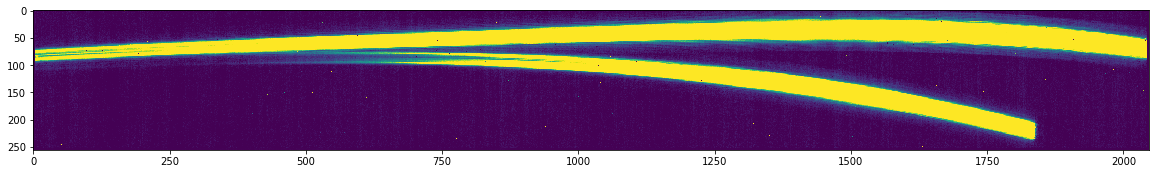

In [9]:
plt.figure(figsize=(20,10))
im = plt.imshow(hdul_ramps['SCI'].data[0,:,:])
im.set_clim(0,50)

As can be seen from the product, this is a result of the pipeline in which the bias, dark, non-linearities and other detector-level systematics have been corrected/calibrated (compare this with the uncalibrated data --- see previous notebook)! Most of the structure of the data outside the traces has been removed, which is a good sign that everything is working more or less as expected. Note some vertical strips remain --- these are the so-called "1/f" noise components imprinted by readout electronics on the frame. Real datasets will most likely have these leftover residuals as well. We'll deal with those in the next notebook. 

Having obtained our ramps, let's now jump to Stage 2 of the pipeline.

### B. Stage 2: spectroscopic processing with the JWST pipeline

The Stage 2 processing of the pipeline is an important component because it allows us to extract important information of the target even if, as in this notebook's case, we will not be extracting the spectrum with the pipeline-provided routines. For example, the wavelength solution is attached to our data products once we run it through some of the steps of the pipeline, and calibrations that are important with real data such as flat-fielding can be applied as well. 

In our particular case, the `awesimsoss` v.0.3.3 simulator does not include the effects of inter and intra-pixel variations, so we won't be applying any calibrations from the pipeline here. We'll only be applying the `assign_wcs` step, which assigns various positional information to our frame including the wavelength solution. Let's apply this step to the ramps:

In [10]:
calwebb_spec2.assign_wcs_step.AssignWcsStep.call('pipeline_outputs/step_LinearityStep_1_rampfitstep.fits', \
                                                 output_dir='pipeline_outputs',save_results=True)

2020-08-22 14:36:19,977 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-08-22 14:36:19,993 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-08-22 14:36:20,983 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('pipeline_outputs/step_LinearityStep_1_rampfitstep.fits',).
2020-08-22 14:36:20,985 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-08-22 14:37:28,528 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2020-08-22 14:38:15,609 - stpipe.AssignWcsStep - INFO - Saved model in pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits
2020-0

<CubeModel(1198, 256, 2048) from step_LinearityStep_1_assignwcsstep.fits>

There is a wide range of information to extract from these products here, but the one we are most interested with is with the wavelength maps. These have the wavelengths for _each pixel in the current frame_, so we can use them to understand and see how the wavelength solution looks in the entire detector. We can extract those for all orders like so:

In [3]:
# Open assignwcs products:
hdul_wcs = fits.open('pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits')
# Open the same product but within a JWST datamodel:
exposure = datamodels.SpecModel('pipeline_outputs/step_LinearityStep_1_assignwcsstep.fits')
# Get number of rows and columns on the first integration:
rows,columns = hdul_wcs['SCI'].data[0,:,:].shape
# Prepare map that will save the wavelength corresponding to each pixel in the frame:
if not os.path.exists('wavsol.npy'):
    wavelength_maps = np.zeros([2,rows,columns])
    # Save it:
    for order in [1,2]:
        for row in range(rows):
            for column in range(columns):
                wavelength_maps[order-1,row,column] = exposure.meta.wcs(column, row, order)[-1]
    np.save('wavsol.npy',wavelength_maps)
else:
    wavelength_maps = np.load('wavsol.npy')

Add time-stamps to these products:

In [4]:
times = np.load('times.npy').astype('float64')
times = np.mean((times-3.17766204e-5).reshape(-1, 3), axis=1)

In [5]:
hdul_wcs['INT_TIMES'].columns.del_col('int_mid_BJD_TDB')

ColDefs(
    name = 'integration_number'; format = 'J'
    name = 'int_start_MJD_UTC'; format = 'D'
    name = 'int_mid_MJD_UTC'; format = 'D'
    name = 'int_end_MJD_UTC'; format = 'D'
    name = 'int_start_BJD_TDB'; format = 'D'
    name = 'int_end_BJD_TDB'; format = 'D'
)

In [6]:
new_col = fits.ColDefs([fits.Column(name='int_mid_BJD_TDB', format='D', array=times)])

In [7]:
orig_cols = hdul_wcs['INT_TIMES'].columns

In [9]:
hdul_wcs['INT_TIMES'] = fits.BinTableHDU.from_columns(orig_cols + new_col) # Run this cell twice. First will fail.

In [10]:
hdul_wcs[''].name = 'INT_TIMES'

In [11]:
hdul_wcs['INT_TIMES'].data['int_mid_BJD_TDB']

array([2459775.74400737, 2459775.74426158, 2459775.74451579, ...,
       2459776.04779186, 2459776.04804607, 2459776.04830028])

In [12]:
len(hdul_wcs['INT_TIMES'].data['int_mid_BJD_TDB'])

1198

### C. Injecting a transit spectrum
#### C.1 Tracing
Now add transit spectrum to these calibrated data at the pixel/detector level. To this end, first find trace of the median image:

In [13]:
data = hdul_wcs['SCI'].data
if not os.path.exists('median_image.npy'):
    median_image = np.median(data,axis=0)
    np.save('median_image.npy',median_image)
else:
    median_image = np.load('median_image.npy')

In [14]:
from scipy.ndimage import gaussian_filter1d
def trace_spectrum(image, xstart, ystart, profile_radius = 20, gauss_filter_width = 10, xend = None):
    """
    Function that non-parametrically traces NIRISS/SOSS spectra. First, to get the centroid at xstart and 
    ystart, it convolves the spatial profile with a gaussian filter, finding its peak through usual flux-weighted 
    centroiding. Next, it uses a smoothed shape in this column to find the centroid of the next, left column, 
    through cross-correlation of that shape.
    
    Parameters
    ----------
    image: ndarray
        The image that wants to be traced.
    xstart: float
        The x-position (column) on which the tracing algorithm will be started
    ystart: float
        The estimated y-position (row) of the center of the trace. An estimate within 10-20 pixels is enough.
    profile_radius: float
        Expected radius of the profile measured from its center. Only this region will be used to estimate 
        the centroids of the spectrum.
    gauss_filter_width: float
        Width of the gaussian filter used to perform the centroiding of the first column
    xend: int
        x-position at which tracing ends. If none, trace all the columns left to xstart.
    """
    # Define x-axis:
    if xend is not None:
        x = np.arange(xend,xstart)
    else:
        x = np.arange(0,xstart)
    # Define y-axis:
    y = np.arange(image.shape[0])
    # Define array that will save centroids at each x:
    ycentroids = np.zeros(len(x))
    for i in range(len(x))[::-1]:
        xcurrent = x[i]
        # Convolve column with a gaussian filter; remove median before convolving:
        filtered_column = gaussian_filter1d(image[:,xcurrent] - np.median(image[:,xcurrent]), gauss_filter_width)
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-ystart)<profile_radius)[0]
        ycentroids[i] = np.sum(y[idx]*filtered_column[idx])/np.sum(filtered_column[idx])
        ystart = ycentroids[i]
    # Check for nans:
    idx = np.where(~np.isnan(ycentroids))
    return x[idx],ycentroids[idx]

Trace spectrum:

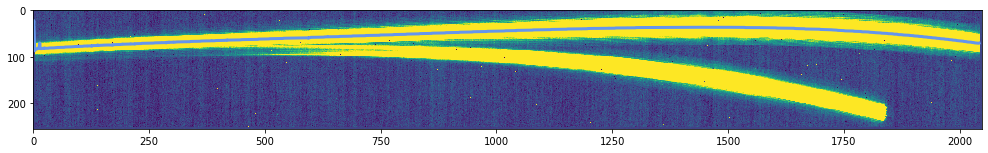

In [15]:
# Define variables for the tracing algorithm:
xstart = 2043
ystart = 70

# Prepare median image plot, on top of which we'll show the traces:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)

# Iterate tracing through all integrations:
x1,y1 = trace_spectrum(median_image, xstart, ystart)
plt.plot(x1,y1,color='cornflowerblue',lw=3)

Fit best polynomial possible:

2020-08-22 22:10:19,072 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py:1647: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)



Best order was:  14


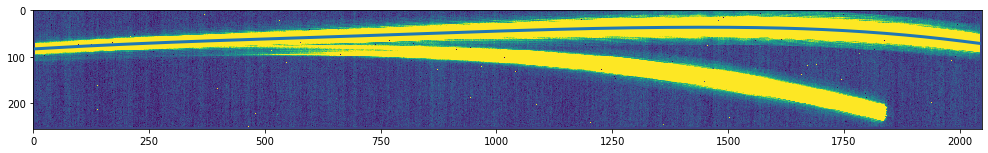

In [16]:
from numpy.polynomial import chebyshev
def select_cheby_order(x,y,min_order,max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order,max_order)
    bics = np.zeros(len(orders))
    n = len(x)
    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x,y,deg=order)
        RSS = np.sum((y - chebyshev.chebval(x,coeffs))**2)
        bics[i] = n*np.log(RSS/n) + (order+1)*np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]

# Try orders from 1 to 30 in the polynomial for all the traces:
order = select_cheby_order(x1[30:],y1[30:],1,30)
print('Best order was: ',order)

# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
coeffs1 = chebyshev.chebfit(x1[30:],y1[30:],deg=order)
plt.plot(x1,chebyshev.chebval(x1,coeffs1),lw=3)

Repeat for order 2:

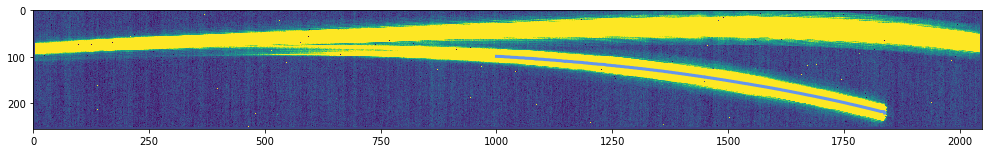

In [17]:
mask = np.zeros(median_image.shape)
mask[80:,:] = np.ones(mask[80:,:].shape)
xstart = 1839
ystart = 225
xend = 1000

# Prepare arrays that will save our results for order 2:
x2 = np.zeros(xstart-xend)
y2 = np.zeros(xstart-xend)

# Prepare median image plot, on top of which we'll show the traces:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)

# Iterate tracing through all integrations:
x2,y2 = trace_spectrum(median_image*mask, xstart, ystart, xend = xend)
plt.plot(x2,y2,color='cornflowerblue',lw=3)

Fit order 2 traces:

2020-08-22 22:11:46,129 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/numpy/polynomial/chebyshev.py:1647: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)



Best order was:  12


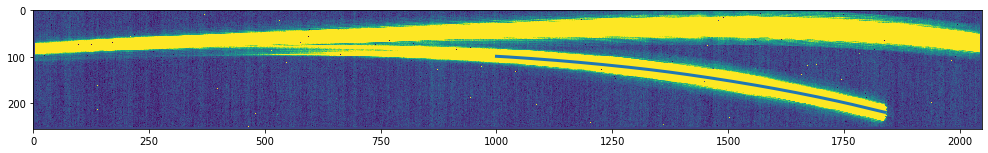

In [18]:
# Try orders from 1 to 30 in the polynomial for all the traces:
order = select_cheby_order(x2,y2,1,30)
print('Best order was: ',order)

# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:
plt.figure(figsize=(17,12))
im = plt.imshow(median_image)
im.set_clim(-5,20)
coeffs2 = chebyshev.chebfit(x2,y2,deg=order)
plt.plot(x2,chebyshev.chebval(x2,coeffs2),lw=3)

#### C.2 Wavelenght solution

Now that we have the traces, let's get the wavelengths corresponding to each order/column combination. To this end, let's just collapse the wavelength solution onto the columns:

In [19]:
avg_waves = np.mean(wavelength_maps,axis=1)
# Get wavelengths corresponding to x1 (order 1 columns) and x2 (order 2 columns):
w1, w2 = avg_waves[0,x1.astype('int')], avg_waves[1,x2.astype('int')]  

#### C.3 Transit lightcurve injection

Let's now inject transit lightcurves at the pixel level. For this, first compute LD coefficients --- we'll use the Order 1 LDs for both Order 1 and Order 2 for the purposes of this excercise:

In [20]:
from exoctk import modelgrid
from exoctk.limb_darkening import limb_darkening_fit as lf
from svo_filters import svo
import astropy.units as q

model_grid = modelgrid.ATLAS9(resolution=700)
model_grid.customize(Teff_rng=(5500,6500), logg_rng=(4.0,4.5), FeH_rng=(0.0,0.5))
ld = lf.LDC(model_grid)

niriss_order1 = svo.Filter('NIRISS.GR700XD.1', wave_min=0.5*q.um, wave_max=3.0*q.um,n_bins=300)
ld.calculate(5980., 4.36, 0.1, 'quadratic', bandpass=niriss_order1) 

# Load results:
ld_data = ld.results

# Get coefficients as numpy arrays:
wld,u1,u2 = np.array(ld_data['wave_eff'].tolist()), np.array(ld_data['c1'].tolist()), np.array(ld_data['c2'].tolist()) 

from scipy.interpolate import interp1d
# Interpolate LD coefficients:
f1 = interp1d(wld,u1)
f2 = interp1d(wld,u2)

2020-08-22 22:12:24,779 - stpipe - INFO - Loading KWallet
2020-08-22 22:12:24,782 - stpipe - INFO - Loading SecretService
2020-08-22 22:12:24,785 - stpipe - INFO - Loading Windows
2020-08-22 22:12:24,788 - stpipe - INFO - Loading chainer
2020-08-22 22:12:24,789 - stpipe - INFO - Loading macOS
2020-08-22 22:12:24,791 - stpipe - INFO - Loading KWallet
2020-08-22 22:12:24,792 - stpipe - INFO - Loading SecretService
2020-08-22 22:12:24,793 - stpipe - INFO - Loading Windows
2020-08-22 22:12:24,794 - stpipe - INFO - Loading chainer
2020-08-22 22:12:24,794 - stpipe - INFO - Loading macOS


Could not determine exoctk version
330 models loaded from /Users/nespinoza/exoctk_data/modelgrid/ATLAS9/
20/330 spectra in parameter range Teff:  (5500, 6500) , logg:  (4.0, 4.5) , FeH:  (0.0, 0.5) , wavelength:  (<Quantity 0. um>, <Quantity 40. um>)
Loading flux into table...
100.00 percent complete!
Bandpass trimmed to 0.5 um - 3.0 um
300 bins of 7 pixels each.
Interpolating grid point [5980.0/4.36/0.1]...
Run time in seconds:  1.409250020980835


Load the transit spectrum:

In [21]:
file_path = download_file('https://data.science.stsci.edu/redirect/'+\
                              'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/'+\
                              'data/hp1_tspec.dat')
wavelength_model, transit_depth_model = np.loadtxt(file_path,unpack=True)
print(np.min(wavelength_model),np.max(wavelength_model))
# Interpolate transit spectrum (on Rp/Rs):
transit_spectrum = interp1d(wavelength_model, np.sqrt(transit_depth_model))

0.200020002 666.66666667


(0.5, 3.0)

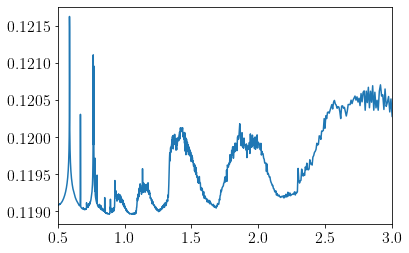

In [22]:
plt.plot(wavelength_model,transit_spectrum(wavelength_model))
plt.xlim([0.5,3.])

Armed with these model values, inject transit. First, define parameters of the transit:

In [23]:
# Now define orbital properties of HAT-P-1b, the exoplanet. First, orbital period and time-of-transit center:
P, mid_transit_time = 4.4652998, 2459775.8911356
# Scaled semi-major axis and planet radius (in units of stellar radius), inclination, eccentricity and 
# argument of periastron passage:
a, rp, inc, ecc, omega = 10.22, 0.116, 85.79, 0., 90.

Define function that will return transit model at a given wavelength:

In [24]:
import batman
def transit_model(w):
    params = batman.TransitParams()
    params.t0 = mid_transit_time # time of inferior conjunction
    params.per = P # orbital period (days)
    params.a = a # semi-major axis (in units of stellar radii)
    if w<np.min(wavelength_model):
        params.rp = transit_spectrum(np.min(wavelength_model)) 
    elif w>np.max(wavelength_model):
        params.rp = transit_spectrum(np.max(wavelength_model)) 
    else:
        params.rp = transit_spectrum(w)
    params.inc = inc # orbital inclination (in degrees)
    params.ecc = ecc # eccentricity
    params.w = omega # longitude of periastron (in degrees) p
    params.limb_dark = 'quadratic' # limb darkening profile to use
    if w<np.min(wld):
        c1,c2 = f1(np.min(wld)),f2(np.min(wld))
    elif w>np.max(wld):
        c1,c2 = f1(np.max(wld)),f2(np.max(wld))
    else:
        c1,c2 = f1(w), f2(w)
    
    params.u = [c1,c2] # limb darkening coefficients

    tmodel = batman.TransitModel(params, hdul_wcs['INT_TIMES'].data['int_mid_BJD_TDB'].astype('float64'))
    return tmodel.light_curve(params)

Now, go through each order, and inject transit model at the pixel level on a 35 pixel radius around the trace:

In [25]:
# Extract calibrated data products:
calibrated_data = np.copy(hdul_wcs['SCI'].data)
test_img = np.ones(hdul_wcs['SCI'].data.shape)
# Radius on which transit will be injected:
radius = 35

# Inject transit:
for order in [1,2]:
    if order == 1:
        xx, ww, coeff = np.copy(x1), np.copy(w1), np.copy(coeffs1)
    else:
        xx, ww, coeff = np.copy(x2), np.copy(w2), np.copy(coeffs2)
    for i in range(len(xx)):
        lc_model = transit_model(ww[i])
        for j in range(len(lc_model)):
            if lc_model[j] != 1.:
                ycenter = chebyshev.chebval(xx[i],coeff)
                left = int(np.max([ycenter - radius,0]))
                right = int(np.min([ycenter + radius, 256]))
                calibrated_data[j,left:right,int(xx[i])] = calibrated_data[j,left:right,int(xx[i])]*lc_model[j]
                test_img[j,left:right,int(xx[i])] = test_img[j,left:right,int(xx[i])]*lc_model[j]

Test in some pixels that this worked:

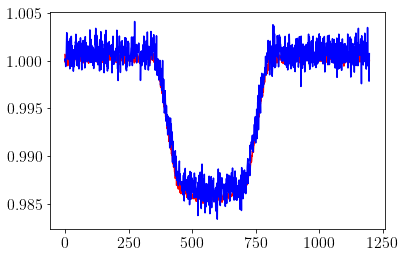

In [26]:
red_region = np.sum(np.sum(calibrated_data[:,50:70,700:1000],axis=1),axis=1)
blue_region = np.sum(np.sum(calibrated_data[:,50:70,1400:1500],axis=1),axis=1)
plt.plot(red_region/np.median(red_region),color='red')
plt.plot(blue_region/np.median(blue_region),color='blue')

Success (yay!). Save to HDUL, and write that HDUL for usage on the data analysis notebook:

In [27]:
hdul_wcs['SCI'].data = calibrated_data
hdul_wcs.writeto('calibrated_data_hatp1_transit.fits')